# 1. import libraries

In [1]:
# Importar librerías de manipulación de datos y visualización
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importar herramientas de preprocesamiento y modelado de sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Importar herramientas de codificación de variables categóricas
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder

# 2. Load the dataset

In [2]:
data = pd.read_csv('churn_kevin.csv')

In [3]:
data.head()

,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,...,20,0.00,59.65,3,Churned,Yes,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,...,0,390.80,1024.10,3,Churned,Yes,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,Male,71,No,Yes,No,Yes,3,United States,California,...,0,203.94,1910.88,2,Churned,Yes,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,United States,California,...,0,494.00,2995.07,2,Churned,Yes,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,United States,California,...,0,234.21,3102.36,2,Churned,Yes,67,2793,Price,Extra data charges


# 3. Data Splitting

# 4. Exploratory Data Analysis

In [ ]:
print("\nDescripción estadística de las columnas numéricas:")
print(data.describe())

In [ ]:
# Histograma para cada variable numérica
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[col].dropna(), bins=30, kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

In [ ]:
# Revisión de las variables categóricas
categorical_columns = data.select_dtypes(include=['object']).columns
print("\nVariables categóricas y sus valores únicos:")
for col in categorical_columns:
    print(f"\n{col}:")
    print(data[col].value_counts())

# Visualización de las variables categóricas con gráficos de barras
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data, x=col)
    plt.title(f'Distribución de la variable categórica {col}')
    plt.xticks(rotation=45)
    plt.show()

las de Total Refunds, Total Extra Data Charges y Number of Referrals, están altamente sesgadas a la derecha. Considera aplicar transformaciones como logaritmos o raíces cuadradas para reducir la asimetría, especialmente en modelos sensibles a la escala y a la distribución de los datos, como la regresión logística.

Variables como Zip Code, Latitude, y Longitude pueden no ser relevantes para el análisis de churn. 

In [ ]:
data.groupby('Churn Label')['Age'].mean()


Los clientes con Churn Label = Yes parecen tener una edad promedio más alta en comparación con aquellos con Churn Label = No.

In [ ]:
data.groupby('Churn Label')['Dependents'].value_counts(normalize=True)


 menor proporción de clientes con dependientes tienden a hacer churn en comparación con aquellos sin dependientes.

In [ ]:
data.groupby('Churn Label')[['Monthly Charge', 'Total Charges']].mean()


 Los clientes con Churn Label = Yes tienden a tener un cargo mensual promedio más alto, pero un cargo total promedio más bajo, lo cual podría indicar que dejan de usar el servicio antes de acumular cargos elevados a largo plazo.

In [ ]:
data.groupby('Churn Label')['Contract'].value_counts(normalize=True)


In [ ]:
# Proporción de churn por tipo de contrato
contract_churn = data.groupby('Contract')['Churn Label'].value_counts(normalize=True).unstack()
print(contract_churn)

# Visualización
contract_churn.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])
plt.title('Proporción de churn por tipo de contrato')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Proporción')
plt.legend(['No Churn', 'Churn'])
plt.show()


Los clientes con contratos de mes a mes tienen una mayor probabilidad de hacer churn. Esto podría sugerir que los contratos más cortos (y por lo tanto más flexibles) no ofrecen suficientes incentivos para mantener a los clientes a largo plazo. Una estrategia podría ser explorar incentivos para migrar a contratos más largos o agregar beneficios en los contratos de mes a mes que aumenten la lealtad.


Hay una mayor tendencia al churn en los contratos de mes a mes, mientras que los contratos de un año y dos años tienen tasas de churn significativamente más bajas.

In [ ]:
data.groupby('Churn Label')['Payment Method'].value_counts(normalize=True)


 Los clientes que usan el retiro bancario tienen una mayor tasa de churn en comparación con otros métodos de pago.

¿Los clientes con dependientes tienden a quedarse más tiempo?

In [ ]:
# Comparación de tenure en meses para clientes con y sin dependientes
tenure_dependents = data.groupby('Dependents')['Tenure in Months'].mean()
print(tenure_dependents)

# Visualización
data.boxplot(column='Tenure in Months', by='Dependents')
plt.title('Distribución de Tenure in Months por Dependencia')
plt.suptitle('')
plt.xlabel('Dependents')
plt.ylabel('Tenure in Months')
plt.show()


La caja de valores de "Tenure in Months" por dependencia muestra que los clientes con dependientes tienden a tener una distribución ligeramente más alta de duración en comparación con los clientes sin dependientes. Esto podría indicar una tendencia de los clientes con dependientes a quedarse un poco más tiempo, aunque el rango de valores en ambos grupos es amplio.

¿Existen patrones claros de gasto o satisfacción entre los clientes que cancelan?

In [ ]:
# Promedio de Monthly Charge, Total Charges y Satisfaction Score por Churn Label
churn_expense_satisfaction = data.groupby('Churn Label')[['Monthly Charge', 'Total Charges', 'Satisfaction Score']].mean()
print(churn_expense_satisfaction)

# Visualización
churn_expense_satisfaction.plot(kind='bar', color=['lightblue', 'salmon', 'green'])
plt.title('Promedio de Gastos y Satisfacción por Churn Label')
plt.xlabel('Churn Label')
plt.ylabel('Promedio')
plt.legend(['Monthly Charge', 'Total Charges', 'Satisfaction Score'])
plt.show()


El gráfico de barras de "Promedio de Gastos y Satisfacción por Churn Label" muestra que los clientes que hacen churn tienen un gasto mensual promedio (Monthly Charge) más alto en comparación con aquellos que permanecen, pero sus cargos totales (Total Charges) son menores. Además, la satisfacción de los clientes que hacen churn es mucho menor que la de los clientes que permanecen. Esto sugiere que los clientes que cancelan tienden a ser menos satisfechos y a incurrir en cargos mensuales más altos, aunque tienen una duración menor en el servicio, lo que lleva a un cargo total menor en promedio.


In [ ]:
Enfoque Propuesto
Modelado Predictivo:

Construir un modelo predictivo para identificar a los clientes con alta probabilidad de churn, usando los hallazgos del análisis exploratorio. Las variables clave identificadas (contrato, satisfacción, dependientes, y tipo de pago) serán especialmente relevantes en la modelación.
Segmentación y Personalización:

Utilizar el modelo para segmentar a los clientes en grupos de riesgo y personalizar las estrategias de retención. Por ejemplo, ofrecer descuentos o beneficios específicos a clientes de alto riesgo.
Optimización del Servicio:

Investigar y abordar las causas específicas de la insatisfacción en clientes de alto churn. Esto puede incluir encuestas o análisis de feedback.

In [ ]:
data["Churn Label"].value_counts()

In [ ]:
sns.countplot(data["Churn Label"])

In [ ]:

  
# Calcula el número de clientes que se quedaron y los que se fueron
num_retained = data[data['Churn Label'] == 'No'].shape[0]
num_churned = data[data['Churn Label'] == 'Yes'].shape[0]

# Imprime el porcentaje de clientes que se quedaron
print(num_retained / (num_retained + num_churned) * 100, '% de clientes se quedaron con la compañía.')

# Imprime el porcentaje de clientes que se fueron
print(num_churned / (num_retained + num_churned) * 100, '% de clientes se fueron de la compañía.')

In [ ]:
sns.countplot(x= "Gender",hue ="Churn Label", data=data)

In [ ]:
sns.countplot(x= "Internet Type",hue ="Churn Label", data=data)

In [ ]:
numerical_features=["Tenure in Months","Monthly Charge"]
# Crear subplots para cada característica
fig, ax = plt.subplots(1, 2, figsize=(28, 8))

# Generar histogramas para los clientes que no abandonaron (Churn Label = No)
data[data['Churn Label'] == 'No'][numerical_features].hist(bins=20, color='blue', alpha=0.5, ax=ax)

# Generar histogramas para los clientes que abandonaron (Churn Label = Yes)
data[data['Churn Label'] == 'Yes'][numerical_features].hist(bins=20, color='orange', alpha=0.5, ax=ax)

# Mostrar el gráfico
plt.show()

# 5. Data Processing

## Data Cleaning

In [4]:
print("Valores nulos antes de la imputación:\n", data.isnull().sum())

Valores nulos antes de la imputación:
 Customer ID                             0
Gender                                  0
Age                                     0
Under 30                                0
Senior Citizen                          0
Married                                 0
Dependents                              0
Number of Dependents                    0
Country                                 0
State                                   0
City                                    0
Zip Code                                0
Latitude                                0
Longitude                               0
Population                              0
Quarter                                 0
Referred a Friend                       0
Number of Referrals                     0
Tenure in Months                        0
Offer                                3877
Phone Service                           0
Avg Monthly Long Distance Charges       0
Multiple Lines                       

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Under 30                           7043 non-null   object 
 4   Senior Citizen                     7043 non-null   object 
 5   Married                            7043 non-null   object 
 6   Dependents                         7043 non-null   object 
 7   Number of Dependents               7043 non-null   int64  
 8   Country                            7043 non-null   object 
 9   State                              7043 non-null   object 
 10  City                               7043 non-null   object 
 11  Zip Code                           7043 non-null   int64

In [6]:
# Rellenar valores nulos en las columnas especificadas
data['Churn Category'] = data['Churn Category'].fillna('Desconocido')
data['Churn Reason'] = data['Churn Reason'].fillna('Desconocido')

In [7]:
data['Internet Type'] = data['Internet Type'].str.strip()
data['Internet Type'] = data['Internet Type'].replace('None', 'Sin servicio')
data['Internet Type'] = data['Internet Type'].fillna('Sin servicio')

In [8]:
data['Offer'] = data['Offer'].fillna('Sin oferta')

Eliminar duplicados

In [9]:
duplicates = data.duplicated()

Eliminar Customer ID

In [12]:
cleaned_data=data.drop("Customer ID",axis=1)

In [13]:
cleaned_data.shape

(7043, 49)

Convertir todas las columnas no numéricas a numéricas

In [14]:
# Convertir todas las columnas no numéricas a numéricas
for column in cleaned_data.columns:
    if cleaned_data[column].dtype == np.number:
        continue
    cleaned_data[column] = LabelEncoder().fit_transform(data[column])

C:\Users\DellUSer\AppData\Local\Temp/ipykernel_29348/373822410.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if cleaned_data[column].dtype == np.number:
C:\Users\DellUSer\AppData\Local\Temp/ipykernel_29348/373822410.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if cleaned_data[column].dtype == np.number:
C:\Users\DellUSer\AppData\Local\Temp/ipykernel_29348/373822410.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if cleaned_data[column].dtype == np.number:
C:\Users\DellUSer\AppData\Local\Temp/ipykernel_29348/373822410.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not stri

In [15]:
print(cleaned_data.info())  # Verifica que las columnas sean numéricas


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 49 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7043 non-null   int32  
 1   Age                                7043 non-null   int64  
 2   Under 30                           7043 non-null   int32  
 3   Senior Citizen                     7043 non-null   int32  
 4   Married                            7043 non-null   int32  
 5   Dependents                         7043 non-null   int32  
 6   Number of Dependents               7043 non-null   int64  
 7   Country                            7043 non-null   int32  
 8   State                              7043 non-null   int32  
 9   City                               7043 non-null   int32  
 10  Zip Code                           7043 non-null   int64  
 11  Latitude                           7043 non-null   float

In [16]:
print(cleaned_data.head())  # Muestra una muestra del DataFrame para confirmar


   Gender  Age  Under 30  Senior Citizen  Married  Dependents  \
0       1   59         0               1        0           0   
1       0   55         0               1        1           1   
2       1   52         0               1        0           1   
3       0   59         0               1        1           1   
4       0   61         0               1        1           1   

   Number of Dependents  Country  State  City  ...  Total Extra Data Charges  \
0                     0        0      0   554  ...                         2   
1                     1        0      0   554  ...                         0   
2                     3        0      0   554  ...                         0   
3                     1        0      0   448  ...                         0   
4                     1        0      0  1072  ...                         0   

   Total Long Distance Charges  Total Revenue  Satisfaction Score  \
0                         0.00          59.65              

Data Splitting

In [17]:
from sklearn.model_selection import train_test_split

# 1. Separar las características (X) y el objetivo (y)
X = cleaned_data.drop("Churn Label", axis=1)  # Reemplaza "Churn Label" por el nombre de tu variable objetivo
y = cleaned_data["Churn Label"]

# 2. Dividir el conjunto de datos en entrenamiento (70%) y una parte temporal (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 3. Dividir la parte temporal en validación (15%) y prueba (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Verificar los tamaños de los conjuntos
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_val.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (4930, 48)
Tamaño del conjunto de validación: (1056, 48)
Tamaño del conjunto de prueba: (1057, 48)


## Re-sampling (if needed)

## Feature Engineering

Codificación para Variables Binarias: Las variables categóricas que solo tienen dos valores posibles (e.g., "Yes" / "No") se transforman en variables binarias. Esto permite representar estas variables como 0 o 1, simplificando su uso en modelos de machine learning.

In [18]:
 
# Encoding para variables binarias
binary_columns = ['Phone Service', 'Internet Service', 'Streaming TV', 'Streaming Movies', 'Unlimited Data', 'Gender']
for df in [X_train, X_val, X_test]:
    df[binary_columns] = df[binary_columns].replace({'Yes': 1, 'No': 0})

# OneHot Encoding para variables categóricas
categorical_columns = ['Internet Type', 'Payment Method', 'Offer', 'Contract']
for df in [X_train, X_val, X_test]:
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


OneHot Encoding para Variables Categóricas con Múltiples Categorías: Las variables categóricas que tienen más de dos categorías se codifican usando OneHot Encoding, creando una columna para cada categoría posible. Este método ayuda a representar estas variables sin introducir un orden artificial entre sus valores.

Columnas categóricas: Internet Type, Payment Method, Offer, Contract.

In [19]:
# Crear características adicionales
def add_features(df):
    # Crear la columna de costo mensual ajustado
    df['Adjusted Monthly Cost'] = df['Total Charges'] / (df['Tenure in Months'] + 1)
    
    # Crear la columna de servicios activos totales
    active_services = ['Phone Service', 'Internet Service', 'Streaming TV', 'Streaming Movies']
    df['Total Active Services'] = df[active_services].apply(lambda x: (x == 'Yes').sum(), axis=1)
    
    return df

 

In [21]:
add_features(X_train)

,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,City,...,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Score,CLTV,Churn Category,Churn Reason,Adjusted Monthly Cost,Total Active Services
5963,0,12,0,0,1,0,0,0,0,854,...,1230.08,7531.06,2,2,39,2584,2,7,98.661719,0
1262,1,38,0,0,0,0,0,0,0,203,...,5.55,51.25,2,0,79,210,1,4,45.700000,0
2502,0,45,0,0,0,0,0,0,0,627,...,21.52,91.22,1,0,75,1932,0,0,69.700000,0
3535,1,21,0,0,0,0,0,0,0,309,...,0.00,1790.60,2,2,45,1394,2,7,45.912821,0
228,1,54,0,1,0,0,0,0,0,1034,...,93.45,330.70,0,0,65,1931,3,19,47.450000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5006,0,2,1,0,1,0,0,0,0,153,...,497.34,2959.89,3,2,59,1603,2,7,91.205556,0
2964,0,41,0,0,1,0,0,0,0,592,...,601.55,1626.33,2,2,26,2113,2,7,19.612264,0
6507,0,29,0,0,1,1,3,0,0,265,...,605.15,989.88,2,2,10,1612,2,7,20.405263,0
3870,1,42,0,0,0,1,3,0,0,92,...,344.70,568.60,2,2,20,2447,2,7,22.390000,0


In [22]:
add_features(X_val)

,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,City,...,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Score,CLTV,Churn Category,Churn Reason,Adjusted Monthly Cost,Total Active Services
6945,0,38,0,0,1,1,1,0,0,1023,...,71.16,310.61,3,1,30,65,2,7,79.816667,0
6295,0,21,0,0,1,1,2,0,0,857,...,1087.24,5422.59,4,2,57,2274,2,7,97.621591,0
3442,0,39,0,0,1,0,0,0,0,1025,...,0.00,3166.90,2,2,53,1466,2,7,54.601724,0
3397,0,32,0,0,1,0,0,0,0,48,...,1529.61,5852.46,2,2,4,2647,2,7,64.520149,0
2375,1,43,0,0,0,0,0,0,0,440,...,64.06,97.26,1,0,49,2816,0,1,16.600000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,0,58,0,1,1,0,0,0,0,863,...,13.02,103.62,1,0,77,635,4,8,90.600000,0
838,1,50,0,1,0,0,0,0,0,38,...,28.67,72.67,3,1,30,1676,2,7,44.000000,0
1240,1,30,0,0,1,0,0,0,0,426,...,37.58,205.08,1,0,56,1195,4,8,83.750000,0
5604,1,40,0,0,1,1,3,0,0,840,...,1947.00,6960.00,3,2,7,3227,2,7,75.954545,0


In [23]:
add_features(X_test)

,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,City,...,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Score,CLTV,Churn Category,Churn Reason,Adjusted Monthly Cost,Total Active Services
430,1,46,0,1,0,0,0,0,0,925,...,41.98,223.68,0,0,77,2764,4,8,90.850000,0
4651,0,27,0,0,1,0,0,0,0,458,...,204.54,496.94,2,2,57,1879,2,7,20.885714,0
1082,1,57,0,1,1,0,0,0,0,191,...,0.00,1364.75,2,2,40,1992,2,7,25.273148,0
4027,1,5,1,0,0,0,0,0,0,960,...,206.45,480.80,2,2,53,419,2,7,54.870000,0
5845,1,12,0,0,1,0,0,0,0,1083,...,1978.60,8326.15,3,2,64,3322,2,7,97.654615,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6874,1,44,0,0,0,0,0,0,0,18,...,1537.92,2453.92,4,2,22,1240,2,7,19.083333,0
3920,0,33,0,0,0,0,0,0,0,426,...,614.55,983.65,4,2,27,2452,2,7,24.606667,0
6178,1,27,0,0,1,0,0,0,0,394,...,518.80,3651.55,2,2,10,968,2,7,78.318750,0
5895,0,18,0,0,0,0,0,0,0,649,...,69.84,642.99,2,2,22,723,2,7,71.643750,0


In [24]:
X_train['Adjusted Monthly Cost'].value_counts()

Adjusted Monthly Cost
19.900000     9
20.200000     8
20.050000     7
19.650000     6
19.400000     6
             ..
44.617000     1
91.505172     1
82.512500     1
23.762500     1
100.363333    1
Name: count, Length: 4678, dtype: int64

In [25]:
X_train['Total Active Services'].value_counts()

Total Active Services
0    4930
Name: count, dtype: int64

## Encoding


 

Codificación de Variables Categóricas con Ordinal Encoding y One-Hot Encoding
Para transformar las variables categóricas y hacerlas aptas para los modelos de machine learning, aplicamos dos tipos de codificación: Ordinal Encoding y One-Hot Encoding. Este proceso se lleva a cabo en los conjuntos de entrenamiento, validación y prueba.

Paso 1: Definición de Columnas y Selección de Encoding
Definimos las columnas categóricas para cada tipo de codificación:

Ordinal Encoding: Se aplica a variables categóricas con un orden inherente o con un número reducido de valores específicos. Las columnas seleccionadas para este tipo de encoding son: Dependents, Churn Label, Offer, y Contract.
One-Hot Encoding: Se utiliza para variables categóricas sin un orden específico y que requieren de una representación binaria. Las columnas seleccionadas son: Phone Service, Referred a Friend, Gender, Under 30, Senior Citizen, Married, Internet Service, Internet Type, y Paperless Billing.

In [28]:
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder

# 1. Define las columnas para cada tipo de encoding
ordinal_cols = ["Dependents", "Churn Label", "Offer", "Contract"]
onehot_cols = ["Phone Service", "Referred a Friend", "Gender", "Under 30", 
               "Senior Citizen", "Married", "Internet Service", "Internet Type", 
               "Paperless Billing"]

# Filtra solo las columnas de `X_train`, eliminando la columna objetivo "Churn Label" si está presente
ordinal_cols = [col for col in ordinal_cols if col in X_train.columns]
onehot_cols = [col for col in onehot_cols if col in X_train.columns]

# 2. Crear los encoders
ordinal_encoder = OrdinalEncoder(
    cols=ordinal_cols, 
    mapping=[
        {"col": "Dependents", "mapping": {"Yes": 1, "No": 0}},
        {"col": "Offer", "mapping": {"No recibio Oferta": 0, "Offer E": 1, "Offer D": 2, "Offer C": 3, "Offer B": 4, "Offer A": 5}},
        {"col": "Contract", "mapping": {"Month-to-Month": 0, "One Year": 1, "Two Year": 2}}
    ]
)

onehot_encoder = OneHotEncoder(cols=onehot_cols, use_cat_names=True)

# 3. Aplicar Ordinal Encoding en el conjunto de entrenamiento
encoded_X_train = ordinal_encoder.fit_transform(X_train)
encoded_X_train = onehot_encoder.fit_transform(encoded_X_train)

# 4. Aplicar el mismo encoding en los conjuntos de validación y prueba
encoded_X_val = ordinal_encoder.transform(X_val)
encoded_X_val = onehot_encoder.transform(encoded_X_val)

encoded_X_test = ordinal_encoder.transform(X_test)
encoded_X_test = onehot_encoder.transform(encoded_X_test)

# Verifica los primeros registros para confirmar que el encoding se aplicó correctamente
print(encoded_X_train.head())
print(encoded_X_val.head())
print(encoded_X_test.head())



C:\Users\DellUSer\anaconda3\envs\mi_entorno\lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\DellUSer\anaconda3\envs\mi_entorno\lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\DellUSer\anaconda3\envs\mi_entorno\lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtyp

      Gender_0.0  Gender_1.0  Age  Under 30_0.0  Under 30_1.0  \
5963           1           0   12             1             0   
1262           0           1   38             1             0   
2502           1           0   45             1             0   
3535           0           1   21             1             0   
228            0           1   54             1             0   

      Senior Citizen_0.0  Senior Citizen_1.0  Married_1.0  Married_0.0  \
5963                   1                   0            1            0   
1262                   1                   0            0            1   
2502                   1                   0            0            1   
3535                   1                   0            0            1   
228                    0                   1            0            1   

      Dependents  ...  Total Long Distance Charges  Total Revenue  \
5963        -1.0  ...                      1230.08        7531.06   
1262        -1.0  ...     

C:\Users\DellUSer\anaconda3\envs\mi_entorno\lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\DellUSer\anaconda3\envs\mi_entorno\lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\DellUSer\anaconda3\envs\mi_entorno\lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtyp

## Scaling (if needed)

# 5. Train model/Tune hyperparameters

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [32]:
# Instanciar el modelo base
rf_model = RandomForestClassifier(random_state=42)

# Definir el grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


In [34]:
# Configurar RandomizedSearchCV con ajustes reducidos
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid,
                                   n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Entrenar el modelo (opcionalmente con una muestra de los datos)
random_search.fit(encoded_X_train.sample(frac=0.3, random_state=42), y_train.sample(frac=0.3, random_state=42))



Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

In [35]:
# Obtener el mejor modelo encontrado por RandomizedSearchCV
best_model = random_search.best_estimator_

# Evaluar en el conjunto de validación
y_val_pred = best_model.predict(encoded_X_val)
from sklearn.metrics import classification_report, accuracy_score

# Imprimir el reporte de clasificación y la precisión
print("Reporte de clasificación en el conjunto de validación:")
print(classification_report(y_val, y_val_pred))
print("Precisión en el conjunto de validación:", accuracy_score(y_val, y_val_pred))


Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       776
           1       1.00      1.00      1.00       280

    accuracy                           1.00      1056
   macro avg       1.00      1.00      1.00      1056
weighted avg       1.00      1.00      1.00      1056

Precisión en el conjunto de validación: 1.0


In [36]:
from sklearn.metrics import classification_report, accuracy_score

# Realizar predicciones en el conjunto de prueba
y_pred_test = random_search.best_estimator_.predict(encoded_X_test)

# Reporte de clasificación en el conjunto de prueba
print("Reporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred_test))

# Calcular precisión en el conjunto de prueba
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Precisión en el conjunto de prueba: {test_accuracy}")


Reporte de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       776
           1       1.00      1.00      1.00       281

    accuracy                           1.00      1057
   macro avg       1.00      1.00      1.00      1057
weighted avg       1.00      1.00      1.00      1057

Precisión en el conjunto de prueba: 1.0


In [37]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15]
}


In [38]:
# Crear el modelo de RandomForest
rf_model = RandomForestClassifier(random_state=42)

# Configurar RandomizedSearchCV con los parámetros ajustados
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Entrenar el modelo en los datos de entrenamiento
random_search.fit(encoded_X_train, y_train)

# Predecir en el conjunto de prueba y generar el reporte de clasificación
y_pred_test = random_search.best_estimator_.predict(encoded_X_test)
print("Reporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Reporte de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       776
           1       1.00      1.00      1.00       281

    accuracy                           1.00      1057
   macro avg       1.00      1.00      1.00      1057
weighted avg       1.00      1.00      1.00      1057



In [39]:
 
feature_importances = pd.Series(random_search.best_estimator_.feature_importances_, index=encoded_X_train.columns)
feature_importances.sort_values(ascending=False).head(10)  # Muestra las 10 características más importantes


Customer Status        0.254477
Satisfaction Score     0.213624
Churn Category         0.153544
Churn Reason           0.138605
Churn Score            0.129516
Tenure in Months       0.018638
Number of Referrals    0.014159
Total Charges          0.007979
Internet Type_2.0      0.007210
Total Revenue          0.007012
dtype: float64

In [40]:
# Lista de columnas a eliminar para evitar sobreajuste
columns_to_drop = ['Customer Status', 'Satisfaction Score', 'Churn Category', 'Churn Reason', 'Churn Score']

# Eliminar estas columnas del conjunto de entrenamiento, validación y prueba
X_train_reduced = X_train.drop(columns=columns_to_drop, axis=1)
X_val_reduced = X_val.drop(columns=columns_to_drop, axis=1)
X_test_reduced = X_test.drop(columns=columns_to_drop, axis=1)


In [41]:
# Configurar y entrenar el modelo con los datos reducidos
random_search.fit(X_train_reduced, y_train)

# Evaluación en el conjunto de validación reducido
y_val_pred = random_search.predict(X_val_reduced)
print("Reporte de clasificación en el conjunto de validación reducido:")
print(classification_report(y_val, y_val_pred))

# Evaluación en el conjunto de prueba reducido
y_test_pred = random_search.predict(X_test_reduced)
print("Reporte de clasificación en el conjunto de prueba reducido:")
print(classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Reporte de clasificación en el conjunto de validación reducido:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       776
           1       0.77      0.57      0.66       280

    accuracy                           0.84      1056
   macro avg       0.81      0.76      0.78      1056
weighted avg       0.83      0.84      0.83      1056

Reporte de clasificación en el conjunto de prueba reducido:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       776
           1       0.83      0.59      0.69       281

    accuracy                           0.86      1057
   macro avg       0.85      0.78      0.80      1057
weighted avg       0.86      0.86      0.85      1057



In [42]:
# Evitar divisiones por cero
X_train['Avg Monthly Charges'] = X_train['Total Charges'] / (X_train['Tenure in Months'] + 1)
X_val['Avg Monthly Charges'] = X_val['Total Charges'] / (X_val['Tenure in Months'] + 1)
X_test['Avg Monthly Charges'] = X_test['Total Charges'] / (X_test['Tenure in Months'] + 1)


In [43]:
X_train['Referrals per Month'] = X_train['Number of Referrals'] / (X_train['Tenure in Months'] + 1)
X_val['Referrals per Month'] = X_val['Number of Referrals'] / (X_val['Tenure in Months'] + 1)
X_test['Referrals per Month'] = X_test['Number of Referrals'] / (X_test['Tenure in Months'] + 1)


In [44]:
X_train['Services per Month'] = X_train['Total Active Services'] / (X_train['Tenure in Months'] + 1)
X_val['Services per Month'] = X_val['Total Active Services'] / (X_val['Tenure in Months'] + 1)
X_test['Services per Month'] = X_test['Total Active Services'] / (X_test['Tenure in Months'] + 1)


In [45]:
X_train['Satisfaction * Monthly Charges'] = X_train['Satisfaction Score'] * X_train['Monthly Charge']
X_val['Satisfaction * Monthly Charges'] = X_val['Satisfaction Score'] * X_val['Monthly Charge']
X_test['Satisfaction * Monthly Charges'] = X_test['Satisfaction Score'] * X_test['Monthly Charge']


In [46]:
print(X_train[['Avg Monthly Charges', 'Referrals per Month', 'Services per Month', 'Satisfaction * Monthly Charges']].head())


      Avg Monthly Charges  Referrals per Month  Services per Month  \
5963            98.661719              0.15625                 0.0   
1262            45.700000              0.00000                 0.0   
2502            69.700000              0.00000                 0.0   
3535            45.912821              0.00000                 0.0   
228             47.450000              0.00000                 0.0   

      Satisfaction * Monthly Charges  
5963                           193.8  
1262                            91.4  
2502                            69.7  
3535                            90.1  
228                              0.0  


# 6. Model performance evaluation

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define un conjunto de hiperparámetros más restrictivos
param_grid = {
    'n_estimators': [10, 20, 30],          # Menos árboles
    'max_depth': [3, 4, 5],                # Máxima profundidad limitada
    'min_samples_split': [15, 20, 25],     # Mayor número de muestras para dividir
    'min_samples_leaf': [10, 15, 20]       # Mayor número de muestras en cada hoja
}

# Inicializa el modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Configura GridSearchCV con una validación cruzada de 10 folds
grid_search = GridSearchCV(rf_model, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Precisión promedio con validación cruzada:", grid_search.best_score_)

# Reporte de clasificación en el conjunto de validación y prueba
from sklearn.metrics import classification_report, accuracy_score

# Validación
y_val_pred = grid_search.best_estimator_.predict(X_val)
print("Reporte de clasificación en el conjunto de validación:")
print(classification_report(y_val, y_val_pred))

# Prueba
y_test_pred = grid_search.best_estimator_.predict(X_test)
print("Reporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_test_pred))


Mejores hiperparámetros: {'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 10}
Precisión promedio con validación cruzada: 1.0
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       776
           1       1.00      1.00      1.00       280

    accuracy                           1.00      1056
   macro avg       1.00      1.00      1.00      1056
weighted avg       1.00      1.00      1.00      1056

Reporte de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       776
           1       1.00      1.00      1.00       281

    accuracy                           1.00      1057
   macro avg       1.00      1.00      1.00      1057
weighted avg       1.00      1.00      1.00      1057



In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Definir el modelo con regularización L2
log_reg = LogisticRegression(solver='liblinear', random_state=42)

# Definir el rango de parámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2']
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Mejor modelo y evaluación
best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

# Mostrar resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Precisión en el conjunto de validación:", accuracy_score(y_val, y_pred_val))
print("Reporte de clasificación en el conjunto de validación:\n", classification_report(y_val, y_pred_val))
print("Reporte de clasificación en el conjunto de prueba:\n", classification_report(y_test, y_pred_test))


Mejores hiperparámetros: {'C': 1, 'penalty': 'l2'}
Precisión en el conjunto de validación: 0.9962121212121212
Reporte de clasificación en el conjunto de validación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       776
           1       0.99      0.99      0.99       280

    accuracy                           1.00      1056
   macro avg       1.00      1.00      1.00      1056
weighted avg       1.00      1.00      1.00      1056

Reporte de clasificación en el conjunto de prueba:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       776
           1       1.00      1.00      1.00       281

    accuracy                           1.00      1057
   macro avg       1.00      1.00      1.00      1057
weighted avg       1.00      1.00      1.00      1057



In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pipeline con selección de características y modelo RandomForest
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif, k=3)),  # Prueba con k=3 para reducir las características
    ('rf', RandomForestClassifier(random_state=42))
])

# Parámetros para el modelo RandomForest y SelectKBest
param_grid = {
    'feature_selection__k': [2, 3, 4],  # Experimenta con menos características
    'rf__n_estimators': [50, 100],  # Reducir la cantidad de árboles para controlar complejidad
    'rf__max_depth': [3, 5, 7],  # Limitar la profundidad de los árboles
    'rf__min_samples_split': [5, 10],  # Aumentar los mínimos para reducir sobreajuste
    'rf__min_samples_leaf': [3, 5]  # Hojas con más muestras para generalizar mejor
}

# GridSearch con validación cruzada para seleccionar hiperparámetros óptimos
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Resultados de evaluación en los conjuntos de validación y prueba
best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

# Imprimir los mejores hiperparámetros y resultados de rendimiento
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Precisión en el conjunto de validación:", accuracy_score(y_val, y_pred_val))
print("Reporte de clasificación en el conjunto de validación:\n", classification_report(y_val, y_pred_val))
print("Reporte de clasificación en el conjunto de prueba:\n", classification_report(y_test, y_pred_test))


C:\Users\DellUSer\anaconda3\envs\mi_entorno\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 7  8 14 49 52] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\DellUSer\anaconda3\envs\mi_entorno\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\DellUSer\anaconda3\envs\mi_entorno\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 7  8 14 49 52] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\DellUSer\anaconda3\envs\mi_entorno\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\DellUSer\anaconda3\envs\mi_entorno\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: User

Mejores hiperparámetros: {'feature_selection__k': 2, 'rf__max_depth': 3, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 5, 'rf__n_estimators': 50}
Precisión en el conjunto de validación: 1.0
Reporte de clasificación en el conjunto de validación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       776
           1       1.00      1.00      1.00       280

    accuracy                           1.00      1056
   macro avg       1.00      1.00      1.00      1056
weighted avg       1.00      1.00      1.00      1056

Reporte de clasificación en el conjunto de prueba:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       776
           1       1.00      1.00      1.00       281

    accuracy                           1.00      1057
   macro avg       1.00      1.00      1.00      1057
weighted avg       1.00      1.00      1.00      1057



C:\Users\DellUSer\anaconda3\envs\mi_entorno\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 7  8 14 49 52] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\DellUSer\anaconda3\envs\mi_entorno\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       776
           1       1.00      1.00      1.00       280

    accuracy                           1.00      1056
   macro avg       1.00      1.00      1.00      1056
weighted avg       1.00      1.00      1.00      1056

Reporte de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       776
           1       1.00      1.00      1.00       281

    accuracy                           1.00      1057
   macro avg       1.00      1.00      1.00      1057
weighted avg       1.00      1.00      1.00      1057



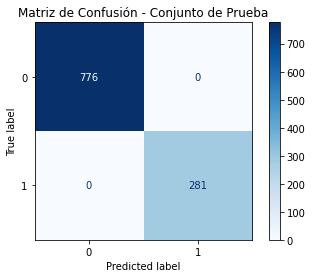

In [54]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generar predicciones en los conjuntos de validación y prueba
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

# Mostrar el reporte de clasificación para el conjunto de validación
print("Reporte de clasificación en el conjunto de validación:")
print(classification_report(y_val, y_pred_val))

# Mostrar el reporte de clasificación para el conjunto de prueba
print("Reporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred_test))

# Visualizar la matriz de confusión para el conjunto de prueba
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.show()


In [61]:
X_train.columns

Index(['Gender', 'Age', 'Under 30', 'Senior Citizen', 'Married', 'Dependents',
       'Number of Dependents', 'Country', 'State', 'City', 'Zip Code',
       'Latitude', 'Longitude', 'Population', 'Quarter', 'Referred a Friend',
       'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Satisfaction Score', 'Customer Status', 'Churn Score',
       'CLTV', 'Churn Category', 'Churn Reason', 'Adjusted Monthly Cost',
       'Total Active Services', 'Avg Monthly Charges'

In [62]:
X_test.columns

Index(['Gender', 'Age', 'Under 30', 'Senior Citizen', 'Married', 'Dependents',
       'Number of Dependents', 'Country', 'State', 'City', 'Zip Code',
       'Latitude', 'Longitude', 'Population', 'Quarter', 'Referred a Friend',
       'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Satisfaction Score', 'Customer Status', 'Churn Score',
       'CLTV', 'Churn Category', 'Churn Reason', 'Adjusted Monthly Cost',
       'Total Active Services', 'Avg Monthly Charges'

In [67]:
print("Shape of X_test:", X_test.shape)
print("Shape of SHAP values:", shap_values[1].shape)


Shape of X_test: (1057, 54)
Shape of SHAP values: (54, 2)


In [65]:
final_model = best_model.named_steps['rf']


Shape of SHAP values for class 1: (1057, 54, 2)
Shape of X_test: (1057, 54)


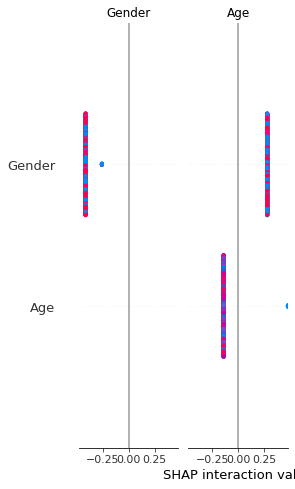

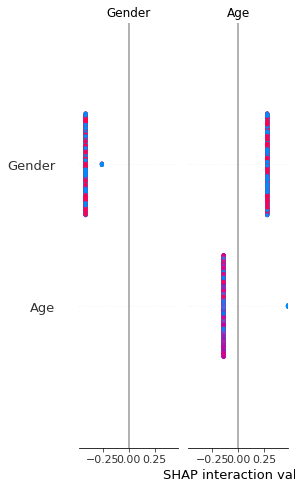

In [68]:

# Extract the trained RandomForestClassifier (or other tree-based model) from the pipeline
final_model = best_model.named_steps['rf']  # Make sure 'rf' is the correct name of your classifier in the pipeline

# Create the SHAP explainer specifically for tree-based models
explainer = shap.TreeExplainer(final_model)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Verify the shape of SHAP values
print("Shape of SHAP values for class 1:", shap_values[1].shape if isinstance(shap_values, list) else shap_values.shape)
print("Shape of X_test:", X_test.shape)

# Plot feature importance using SHAP values, making sure to select the correct SHAP values for class 1 if it's a list
if isinstance(shap_values, list):
    # If shap_values is a list (indicating class-specific SHAP values), we use shap_values[1] for the class of interest
    shap.summary_plot(shap_values[1], X_test, plot_type="bar")  # Bar plot for top features
    shap.summary_plot(shap_values[1], X_test)  # Beeswarm plot for detailed feature impact
else:
    # If shap_values is not a list, use it directly
    shap.summary_plot(shap_values, X_test, plot_type="bar")
    shap.summary_plot(shap_values, X_test)



# 7. Explainability

In [71]:
import shap

# Extract the actual classifier from the pipeline if using one
final_model = best_model.named_steps['rf']  # Adjust 'rf' if the step name is different

# Create a SHAP explainer based on the model type
explainer = shap.TreeExplainer(final_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)



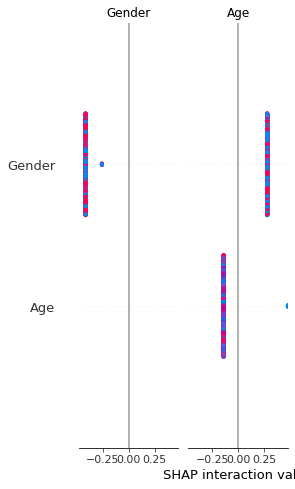

In [72]:
# Check if shap_values is a list (for classification models)
if isinstance(shap_values, list):
    # Use shap_values[1] for class 1 if it's a binary classification
    shap.summary_plot(shap_values[1], X_test, plot_type="bar")
else:
    # Use shap_values directly if not a list
    shap.summary_plot(shap_values, X_test, plot_type="bar")


In [73]:
print("Shape of X_test:", X_test.shape)
print("Shape of SHAP values:", shap_values[1].shape if isinstance(shap_values, list) else shap_values.shape)


Shape of X_test: (1057, 54)
Shape of SHAP values: (1057, 54, 2)
